## Lab-2.1: Multi-variable neural-network regression 

* In this lab we perform multi-variable regression on the Boston housing data-set. 

**Instructions** 
* Code regression using a deep feed forward fully connected Neural network
  * Use a dense feed forward ANN model
  * **You only need to do this week's example with Keras (i.e. no pytorch)**
  * Normalize the data as needed
  * Visualize the results at the end where possible
  * Partition data into training, validation, and test
  * Monitor training and validation throughout training by plotting
  * Print training, validation, and test errors at the very end
  * Do basic hyper parameter tuning to try to achieve an optimal fit model
    * i.e. best training/validation loss without over-fitting
    * Explore L1 and L2 regularization
    * Explore different optimizers 
    * Use the loss functions specified in the textbook
    * Explore different options for activation functions, network size/depth, etc
* **Document what is going on in the code, as needed, with narrative markdown text between cells.**
* *Submit the version with hyper parameters that provide the optimal fit*
  * i.e. you don't need to show the outputs of your hyper-parameter tuning process
  
**Important: The Keras portion of this assignment is included as an example in the text book**
  * See the textbook (Chollet chapter-3, page 85) for reference 
  
**Submission:**
* You need to upload ONE document to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of this notebook 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

### Data preparation 

* Insert cells below

In [1]:
#load the dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [5]:
#normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Keras training

* Insert cells below

In [6]:
from keras import models
from keras import layers
from keras import regularizers
def build_model():
    model = models.Sequential()
    # add l1 and l2 regulations
    model.add(layers.Dense(32, kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                            #bias_regularizer=regularizers.l2(1e-4),
                            #activity_regularizer=regularizers.l2(1e-5),
                            activation='relu',
                            input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    #try different optimizers
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [7]:
#k-fold validation
import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


2022-09-26 19:37:12.986838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_scores

[1.968743085861206, 2.6682288646698, 2.5479612350463867, 2.3079981803894043]

In [9]:
np.mean(all_scores)

2.373232841491699

In [10]:
#saving the validation logs at each fold
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
#build the history of successive mean k-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

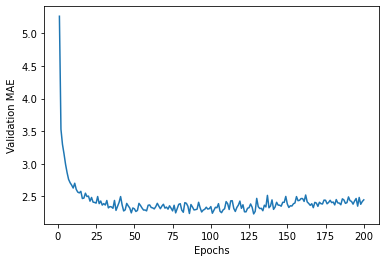

In [12]:
#plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

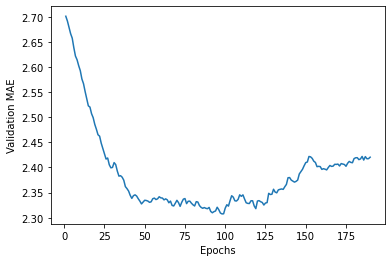

In [13]:
#plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [19]:
#training the final model
model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)
test_mae_score, test_mae_score = model.evaluate (test_data, test_targets) 

test_mae_score

4/4 [==============================] - 0s 789us/step - loss: 21.3349 - mae: 2.8267


2.8267109394073486